In [1]:
import warnings
warnings.filterwarnings("ignore")
from copy import deepcopy
from datetime import datetime
from pathlib import Path

import numpy as np
import pandas as pd
import sys

sys.path.append("/code")

from tqdm import tqdm
import torch
import time
# device = torch.device('cpu')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
# import gym
# import recogym

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim

torch.backends.cudnn.benchmark = torch.cuda.is_available()
if torch.cuda.is_available():
    torch.set_float32_matmul_precision("high")  # TF32 = big speedup on Ada


from sklearn.utils import check_random_state

# implementing OPE of the IPWLearner using synthetic bandit data
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt

from scipy.special import softmax
import optuna
# from memory_profiler import profile

from plots_and_stats import compute_statistics_and_plots, plot_calibration_and_rank_table

from estimators import (
    DirectMethod as DM
)

from simulation_utils import (
    eval_policy,
    generate_dataset,
    create_simulation_data_from_pi,
    get_train_data,
    get_opl_results_dict,
    CustomCFDataset,
    calc_reward,
    get_weights_info
)

from models import (    
    LinearCFModel,
    NeighborhoodModel,
    BPRModel, 
    RegressionModel
)


from trainer_trials_modular import (
    regression_trainer_trial,
    neighberhoodmodel_trainer_trial,
    random_policy_trainer_trial
)


random_state=12345
random_ = check_random_state(random_state)

pd.options.display.float_format = '{:,.8f}'.format

Using device: cuda
Using device: cuda
Using device: cuda


## Learning

We will run several simulations on a generated dataset, the dataset is generated like this:
$$ \text{We have users U and actions A } u_i \sim N(0, I_{emb_dim}) \ a_i \sim N(0, I_{emb_dim})$$
$$ p_{ij} = 1 / (5 + e^{-(u_i.T a_j)}) $$
$$r_{ij} \sim Bin(p_{ij})$$

We have a policy $\pi$
and it's ground truth reward is calculated by
$$R_{gt} = \sum_{i}{\sum_{j}{\pi_{ij} * p_{ij}}} $$

Our parameters for the dataset will be
$$EmbDim = 5$$
$$NumActions= 150$$
$$NumUsers = 150$$
$$NeighborhoodSize = 6$$

to learn a new policy from $\pi$ we will sample from:
$$\pi_{start} = (1-\epsilon)*\pi + \epsilon * \pi_{random}$$

In [2]:
cols = [
    
    'dr_naive_mean', 'dr_naive_ci_low', 'dr_naive_ci_high', 'dr_naive_se',
    'dr_boot_mean', 'dr_boot_std', 'dr_boot_ci_low', 'dr_boot_ci_high',
    'ipw_boot_mean', 'ipw_boot_std', 'ipw_boot_ci_low', 'ipw_boot_ci_high',

    'cv_rmse_uniform', 'cv_signed_rmse_uniform', 'cv_bias_uniform',
    'cv_bias_lb_signed_uniform', 'cv_rmse_exp', 'cv_signed_rmse_exp',
    'cv_bias_exp', 'cv_bias_lb_signed_exp', 'loss_uniform', 'loss_exp',
    'score_naive_minus_cv_uniform', 'score_naive_minus_cv_exp'
    ]

In [3]:
'Spearman Kendall-Tau'.split()

['Spearman', 'Kendall-Tau']

In [4]:
cols = ['dr_naive_mean', 'dr_naive_ci_low',
         'dr_boot_mean', 'dr_boot_ci_low',
         'dr_uni_mean', 'dr_uni_ci_low',
         'ipw_boot_mean', 'ipw_boot_ci_low',
         'ipw_uni_mean', 'ipw_uni_ci_low']

In [5]:
# for num in [10000, 20000, 30000, 40000, 50000, 12345]:
#     df = pd.read_csv(f"trial_dfs/study_df_155_{num}.csv")

#     rank_tbl = plot_calibration_and_rank_table(
#         df,
#         cols=cols,
#         reward_col="user_attrs_actual_reward"
#     )

#     print(f"Num samples: {num}")
#     display(rank_tbl)

In [6]:
# df = pd.read_csv("trial_dfs/study_df_27_40000.csv")

# rank_tbl = plot_calibration_and_rank_table(
#     df,
#     cols=cols,
#     reward_col="user_attrs_actual_reward"
# )

# rank_tbl

In [7]:
dataset_params = dict(
                    n_actions= 500,
                    n_users = 500,
                    emb_dim = 16,
                    # sigma = 0.1,
                    eps = 0.6, # this is the epsilon for the noise in the ground truth policy representation
                    ctr = 0.1
                    )

train_dataset = generate_dataset(dataset_params)

Random Item CTR: 0.07066414727263938
Optimal greedy CTR: 0.09999926940951757
Second Best greedy CTR: 0.0980913477695915
Optimal Stochastic CTR: 0.09995326955796031
second Best Stochastic CTR: 0.08595012935428775
Our Initial CTR: 0.08610747363354625


In [16]:
for n in np.arange(1, 20, 1):
    df, _ = random_policy_trainer_trial(
        train_size=1500 * n,
        dataset=train_dataset,
        n_policies=300,
        val_size=1000 * n,
    )
    df.to_csv(f"trial_dfs/random_trial_{n}_{300}.csv")

Simulation time for 2500 samples: 0.0055959224700927734 seconds
[Regression] Baseline regression model fit time: 0.16s


Validation weights_info: {'gini': np.float64(0.22078325176385424), 'ess': np.float64(680.135733739823), 'max_wi': np.float64(14.711132395234223), 'min_wi': np.float64(0.6226691370699117)}: 100%|██████████| 300/300 [00:19<00:00, 15.73it/s]   


Simulation time for 5000 samples: 0.010274410247802734 seconds
[Regression] Baseline regression model fit time: 0.10s


Validation weights_info: {'gini': np.float64(0.057090106026752845), 'ess': np.float64(1949.7485321257814), 'max_wi': np.float64(3.692505365349405), 'min_wi': np.float64(0.9082901145387744)}: 100%|██████████| 300/300 [00:22<00:00, 13.10it/s] 


Simulation time for 7500 samples: 0.014715433120727539 seconds
[Regression] Baseline regression model fit time: 0.09s


Validation weights_info: {'gini': np.float64(0.47503362330613785), 'ess': np.float64(856.1841929951507), 'max_wi': np.float64(48.23452150507101), 'min_wi': np.float64(0.26690940208513675)}: 100%|██████████| 300/300 [00:26<00:00, 11.28it/s]   


Simulation time for 10000 samples: 0.02049088478088379 seconds
[Regression] Baseline regression model fit time: 0.09s


Validation weights_info: {'gini': np.float64(0.2955713501811605), 'ess': np.float64(2189.5199110198682), 'max_wi': np.float64(34.655755089301834), 'min_wi': np.float64(0.5111343289726344)}: 100%|██████████| 300/300 [00:30<00:00,  9.91it/s]   


Simulation time for 12500 samples: 0.02513599395751953 seconds
[Regression] Baseline regression model fit time: 0.08s


Validation weights_info: {'gini': np.float64(0.5515386007123071), 'ess': np.float64(778.7387558183144), 'max_wi': np.float64(123.64908318955418), 'min_wi': np.float64(0.10503102140031352)}: 100%|██████████| 300/300 [00:33<00:00,  9.09it/s]  


Simulation time for 15000 samples: 0.03108525276184082 seconds
[Regression] Baseline regression model fit time: 0.08s


Validation weights_info: {'gini': np.float64(0.1497989957855707), 'ess': np.float64(5084.287964723705), 'max_wi': np.float64(10.73972204931863), 'min_wi': np.float64(0.7487630433747892)}: 100%|██████████| 300/300 [00:36<00:00,  8.29it/s]    


Simulation time for 17500 samples: 0.034848928451538086 seconds
[Regression] Baseline regression model fit time: 0.08s


Validation weights_info: {'gini': np.float64(0.015308013442886632), 'ess': np.float64(6985.610504489508), 'max_wi': np.float64(2.014549857503385), 'min_wi': np.float64(0.9757742048384617)}: 100%|██████████| 300/300 [00:38<00:00,  7.70it/s]  


Simulation time for 20000 samples: 0.039205074310302734 seconds
[Regression] Baseline regression model fit time: 0.08s


Validation weights_info: {'gini': np.float64(0.30772517957327583), 'ess': np.float64(4632.407350141704), 'max_wi': np.float64(23.794837200973085), 'min_wi': np.float64(0.49278541232176415)}: 100%|██████████| 300/300 [00:42<00:00,  7.13it/s] 


Simulation time for 22500 samples: 0.046526193618774414 seconds
[Regression] Baseline regression model fit time: 0.06s


Validation weights_info: {'gini': np.float64(0.4714887940264402), 'ess': np.float64(3003.43615148457), 'max_wi': np.float64(39.594062180279124), 'min_wi': np.float64(0.2370351909987672)}: 100%|██████████| 300/300 [00:47<00:00,  6.37it/s]    


Simulation time for 25000 samples: 0.0520634651184082 seconds
[Regression] Baseline regression model fit time: 0.64s


Validation weights_info: {'gini': np.float64(0.0958220205966367), 'ess': np.float64(9190.156571503747), 'max_wi': np.float64(15.172398665059452), 'min_wi': np.float64(0.8399446284859391)}: 100%|██████████| 300/300 [00:49<00:00,  6.01it/s]   


Simulation time for 27500 samples: 0.056931257247924805 seconds
[Regression] Baseline regression model fit time: 0.59s


Validation weights_info: {'gini': np.float64(0.25239620414292785), 'ess': np.float64(6559.164004292642), 'max_wi': np.float64(49.778910912931885), 'min_wi': np.float64(0.5837167525640121)}: 100%|██████████| 300/300 [00:53<00:00,  5.58it/s]   


Simulation time for 30000 samples: 0.0611572265625 seconds
[Regression] Baseline regression model fit time: 0.65s


Validation weights_info: {'gini': np.float64(0.23974180404148598), 'ess': np.float64(8309.34849208955), 'max_wi': np.float64(14.778159317727471), 'min_wi': np.float64(0.6075881407849226)}: 100%|██████████| 300/300 [00:56<00:00,  5.29it/s]    


Simulation time for 32500 samples: 0.06747579574584961 seconds
[Regression] Baseline regression model fit time: 0.67s


Validation weights_info: {'gini': np.float64(0.467531328354805), 'ess': np.float64(4828.906964106817), 'max_wi': np.float64(35.57282244739122), 'min_wi': np.float64(0.23004543111828213)}: 100%|██████████| 300/300 [00:59<00:00,  5.06it/s]    


Simulation time for 35000 samples: 0.07342219352722168 seconds
[Regression] Baseline regression model fit time: 0.88s


Validation weights_info: {'gini': np.float64(0.22598553413832226), 'ess': np.float64(9163.004306002638), 'max_wi': np.float64(32.159858273227364), 'min_wi': np.float64(0.6308080480071816)}: 100%|██████████| 300/300 [01:02<00:00,  4.83it/s]  


Simulation time for 37500 samples: 0.07759833335876465 seconds
[Regression] Baseline regression model fit time: 0.40s


Validation weights_info: {'gini': np.float64(0.3821240321222888), 'ess': np.float64(5186.775416210324), 'max_wi': np.float64(93.26863875528896), 'min_wi': np.float64(0.38126448884496494)}: 100%|██████████| 300/300 [01:05<00:00,  4.58it/s]   


Simulation time for 40000 samples: 0.08567547798156738 seconds
[Regression] Baseline regression model fit time: 0.53s


Validation weights_info: {'gini': np.float64(0.49573225557825684), 'ess': np.float64(4061.2637601673687), 'max_wi': np.float64(75.1368345828615), 'min_wi': np.float64(0.2080604911014993)}: 100%|██████████| 300/300 [01:07<00:00,  4.42it/s]    


Simulation time for 42500 samples: 0.08780455589294434 seconds
[Regression] Baseline regression model fit time: 0.72s


Validation weights_info: {'gini': np.float64(0.27192244149832423), 'ess': np.float64(10386.86291124927), 'max_wi': np.float64(23.960419408691237), 'min_wi': np.float64(0.5588984904762263)}: 100%|██████████| 300/300 [01:11<00:00,  4.20it/s]   


Simulation time for 45000 samples: 0.09894824028015137 seconds
[Regression] Baseline regression model fit time: 0.67s


Validation weights_info: {'gini': np.float64(0.24794576274598457), 'ess': np.float64(11602.969946371482), 'max_wi': np.float64(33.54096399359589), 'min_wi': np.float64(0.6004159227921559)}: 100%|██████████| 300/300 [01:14<00:00,  4.03it/s]    


Simulation time for 47500 samples: 0.1019735336303711 seconds
[Regression] Baseline regression model fit time: 0.61s


Validation weights_info: {'gini': np.float64(0.4184799673732955), 'ess': np.float64(7259.356946768552), 'max_wi': np.float64(48.978272693770315), 'min_wi': np.float64(0.32313242579629287)}: 100%|██████████| 300/300 [01:16<00:00,  3.93it/s]   


In [13]:
df, _ = random_policy_trainer_trial(
    train_size=15000,
    dataset=train_dataset,
    n_policies=300,
    val_size=10000,
)

Simulation time for 25000 samples: 0.06912350654602051 seconds
[Regression] Baseline regression model fit time: 0.85s


Validation weights_info: {'gini': np.float64(0.15474701848747074), 'ess': np.float64(8161.469657063368), 'max_wi': np.float64(22.493704908385666), 'min_wi': np.float64(0.742314302538421)}: 100%|██████████| 300/300 [00:48<00:00,  6.15it/s]   


In [17]:
df

,value,user_attrs_actual_reward,user_attrs_q_error,user_attrs_r_hat,user_attrs_ess,user_attrs_scores_dict,user_attrs_all_values
0,0.08203661,0.08258185,0.00144614,0.08492889,"16,046.95973135","{'dr_naive_mean': 0.08492888935979429, 'dr_nai...","[0.08492888935979429, 0.0849852321901692, 0.08..."
1,0.08228710,0.07663758,0.00124429,0.08477567,"8,007.48633846","{'dr_naive_mean': 0.0847756744682755, 'dr_naiv...","[0.0847756744682755, 0.0847484849880716, 0.073..."
2,0.08210038,0.08474173,0.00149538,0.08509114,"18,474.63408746","{'dr_naive_mean': 0.08509114276017654, 'dr_nai...","[0.08509114276017654, 0.0850790679191315, 0.08..."
3,0.08210908,0.08037279,0.00137901,0.08486710,"12,674.93624618","{'dr_naive_mean': 0.08486709993039351, 'dr_nai...","[0.08486709993039351, 0.08484257362956973, 0.0..."
4,0.08225715,0.07628249,0.00122977,0.08471670,"7,811.34239099","{'dr_naive_mean': 0.08471669744506626, 'dr_nai...","[0.08471669744506626, 0.08466239428197507, 0.0..."
...,...,...,...,...,...,...,...
295,0.08246157,0.07071876,0.00103592,0.08453340,"4,165.84770294","{'dr_naive_mean': 0.08453340169821966, 'dr_nai...","[0.08453340169821966, 0.08447129806912115, 0.0..."
296,0.08244631,0.07170233,0.00106509,0.08457649,"4,341.41531597","{'dr_naive_mean': 0.08457649255115611, 'dr_nai...","[0.08457649255115611, 0.0845380762903502, 0.06..."
297,0.08247535,0.07155078,0.00106088,0.08459710,"4,475.97608702","{'dr_naive_mean': 0.08459710187232246, 'dr_nai...","[0.08459710187232246, 0.08453223933789113, 0.0..."
298,0.08206316,0.08430613,0.00148709,0.08503734,"18,101.31242799","{'dr_naive_mean': 0.08503733939596497, 'dr_nai...","[0.08503733939596497, 0.0851216600366525, 0.08..."


In [19]:
df2 = df.copy()
df2['value'] = df2['user_attrs_r_hat']

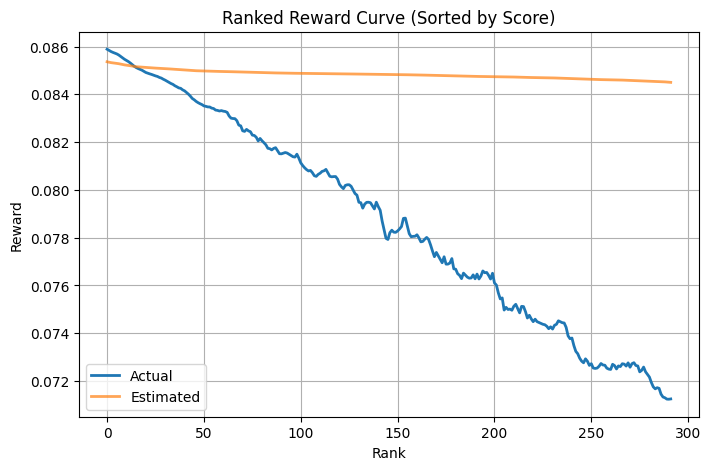

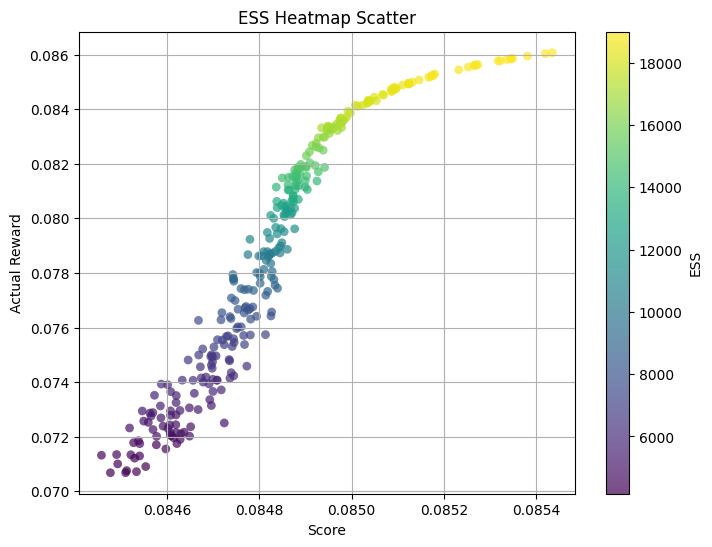

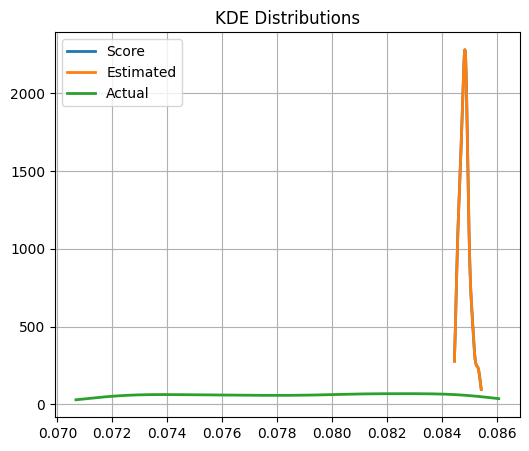

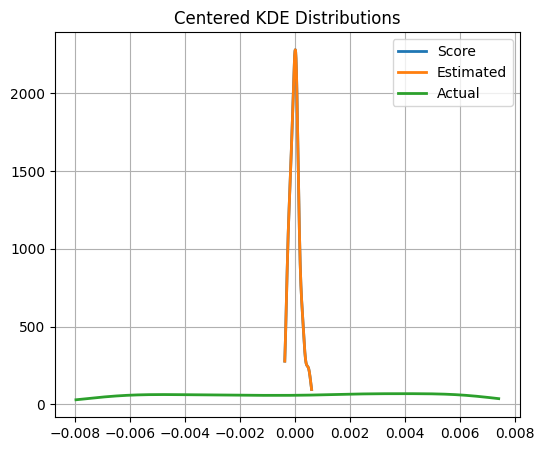

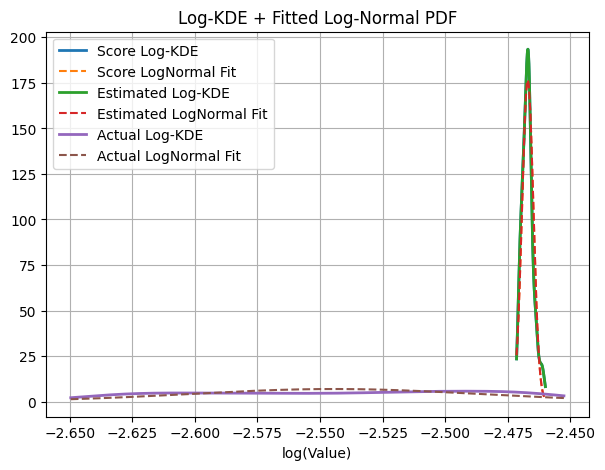

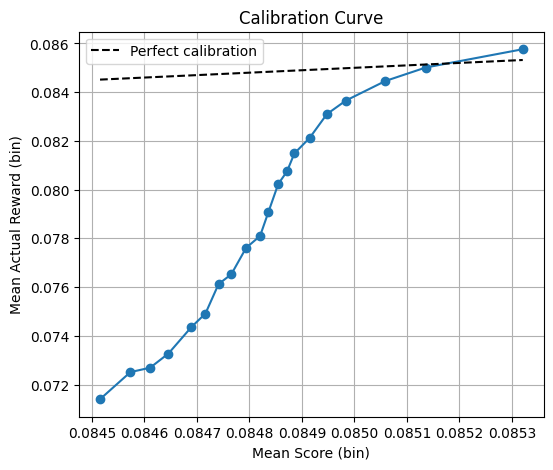

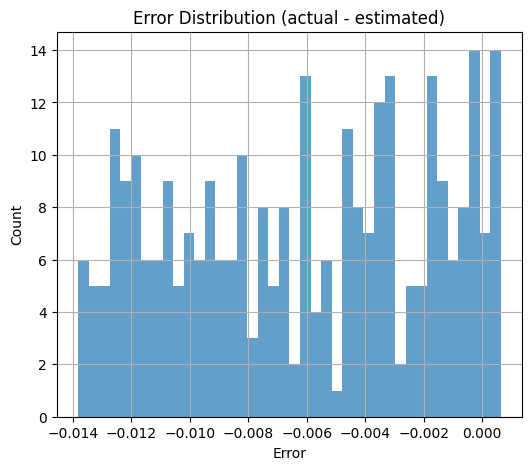

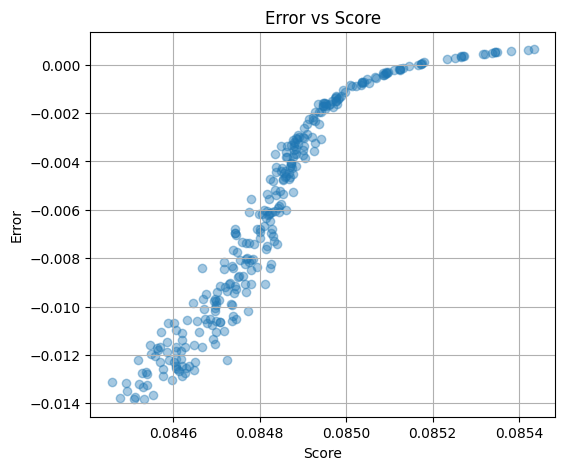

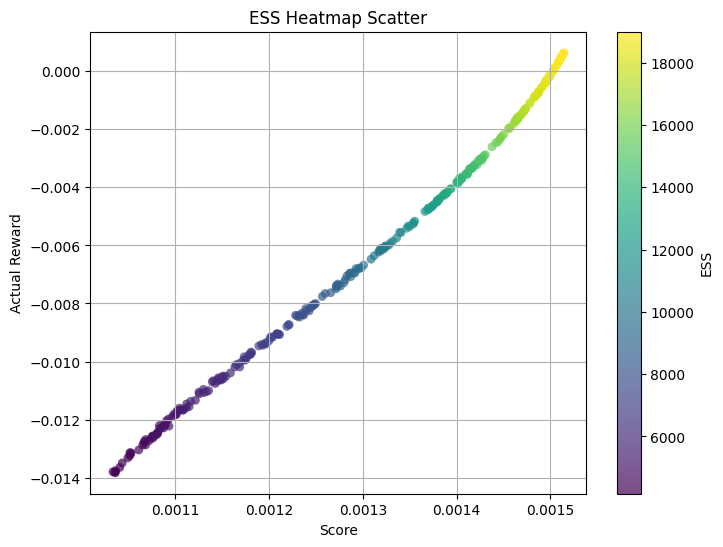

Correlation Metrics: {'pearson_score_actual': np.float64(0.9390603844270323), 'spearman_score_actual': np.float64(0.9860598451093902), 'spearman_est_actual': np.float64(0.9860598451093902)}
NDCG Metrics: {'ndcg_score_actual': np.float64(0.9999332311631222), 'ndcg_est_actual': np.float64(0.9999332311631222)}
Error Metrics: {'mean_error': np.float64(-0.006175877300954942), 'mae': np.float64(0.006221836179711162), 'rmse': np.float64(0.0075477815951441995), 'std_error': np.float64(0.00433907208646584), 'max_error': np.float64(0.0006358481990431653), 'min_error': np.float64(-0.01382915561444012)}


In [20]:
compute_statistics_and_plots(df2)

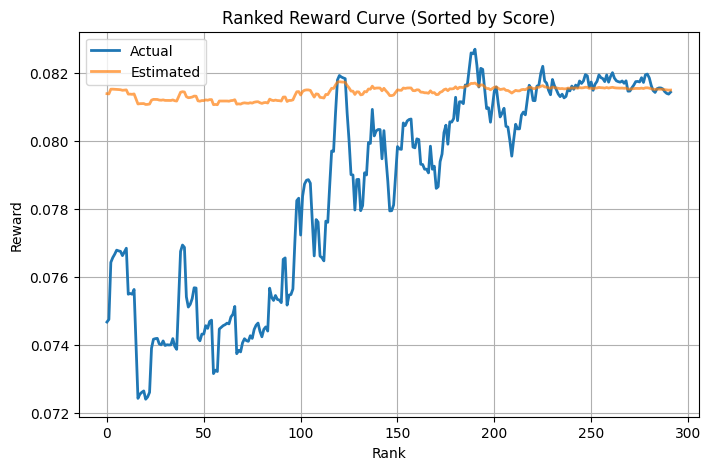

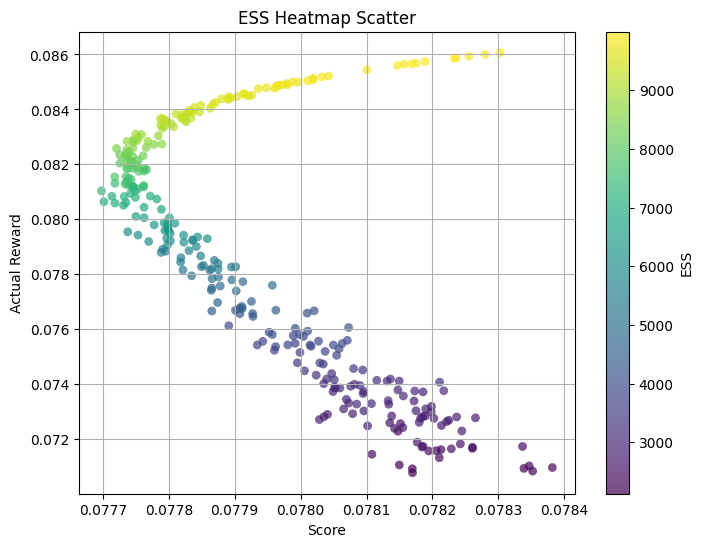

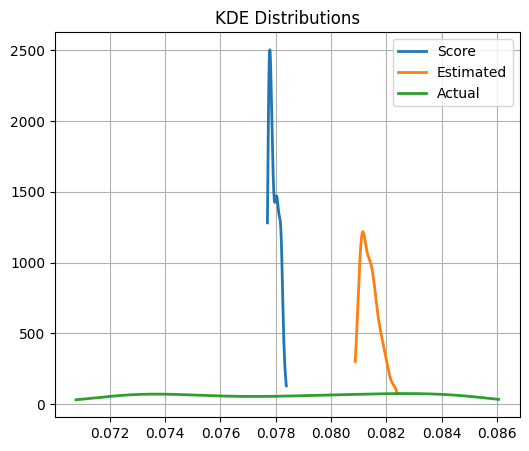

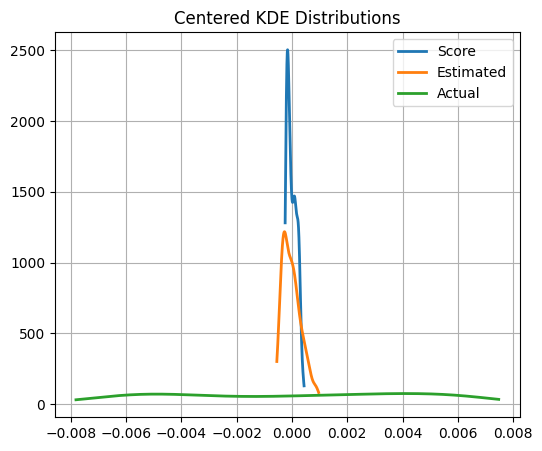

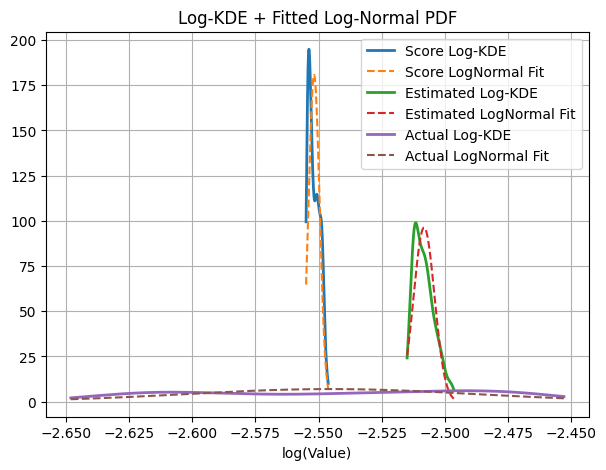

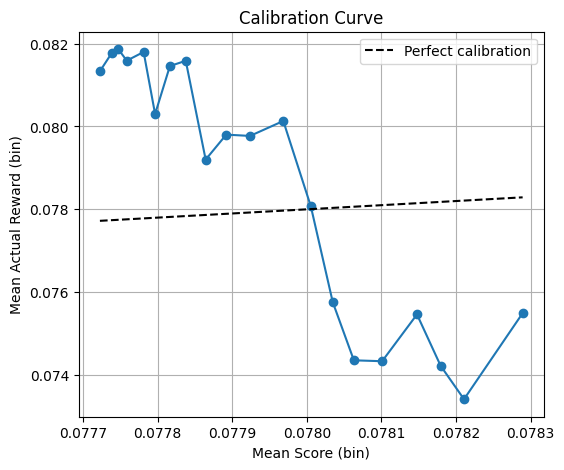

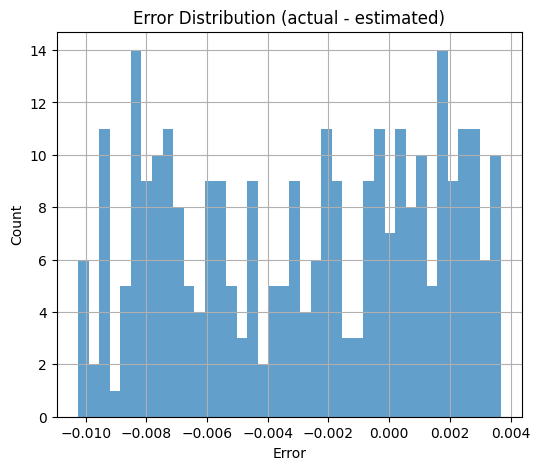

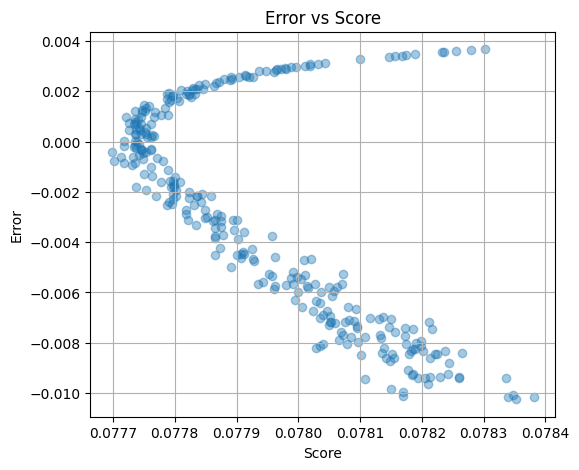

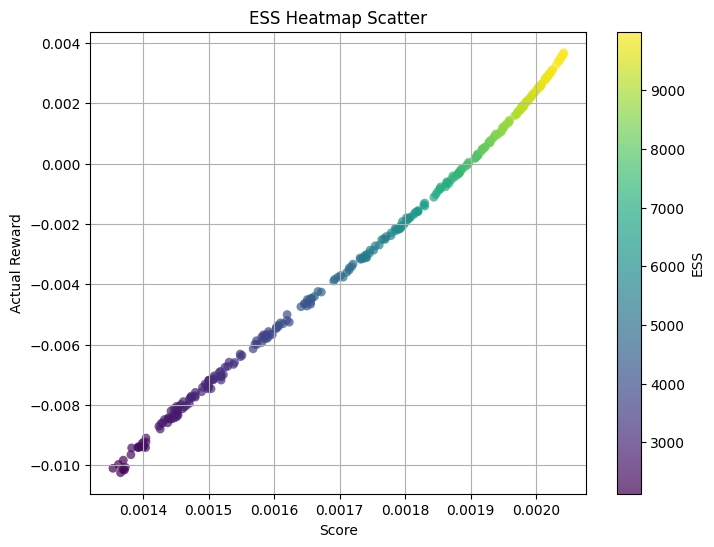

Correlation Metrics: {'pearson_score_actual': np.float64(-0.624923996625001), 'spearman_score_actual': np.float64(-0.5813362370693007), 'spearman_est_actual': np.float64(0.9834651496127734)}
NDCG Metrics: {'ndcg_score_actual': np.float64(0.9758550450058395), 'ndcg_est_actual': np.float64(0.9999470430653504)}
Error Metrics: {'mean_error': np.float64(-0.0028350201072157894), 'mae': np.float64(0.004063282616210191), 'rmse': np.float64(0.005024042978840501), 'std_error': np.float64(0.004147730565612804), 'max_error': np.float64(0.003676040938540473), 'min_error': np.float64(-0.010249442552739324)}


In [14]:
compute_statistics_and_plots(df)

Plotting calibration for: dr_naive_mean


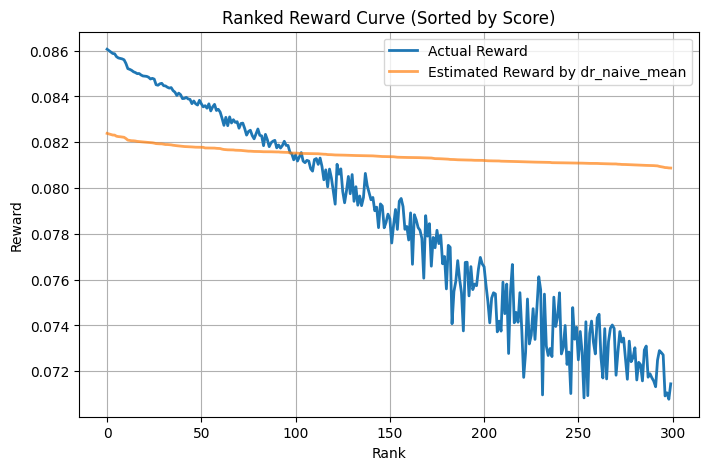

Plotting calibration for: dr_naive_ci_low


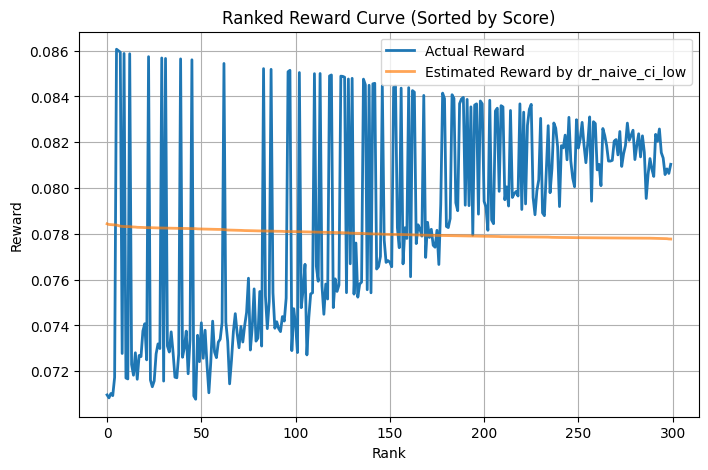

Plotting calibration for: dr_boot_mean


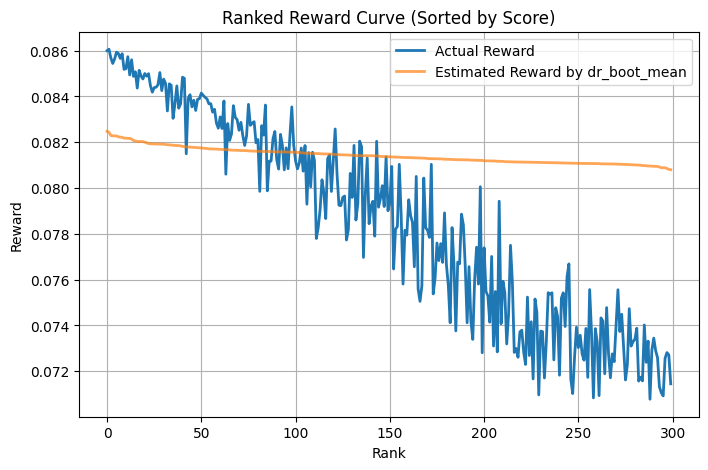

Plotting calibration for: dr_boot_ci_low


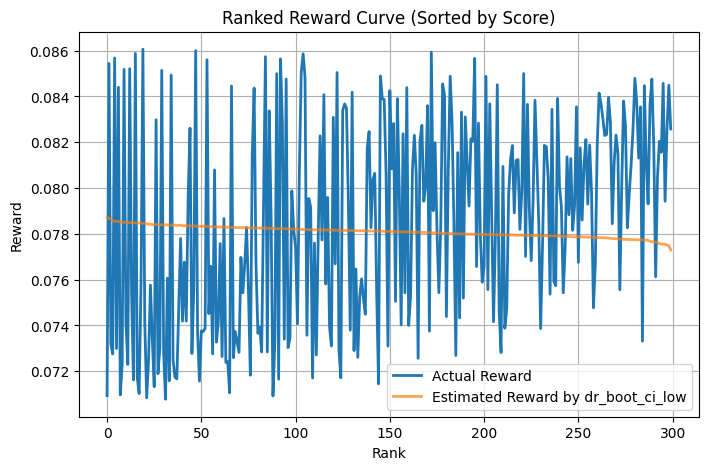

Plotting calibration for: dr_uni_mean


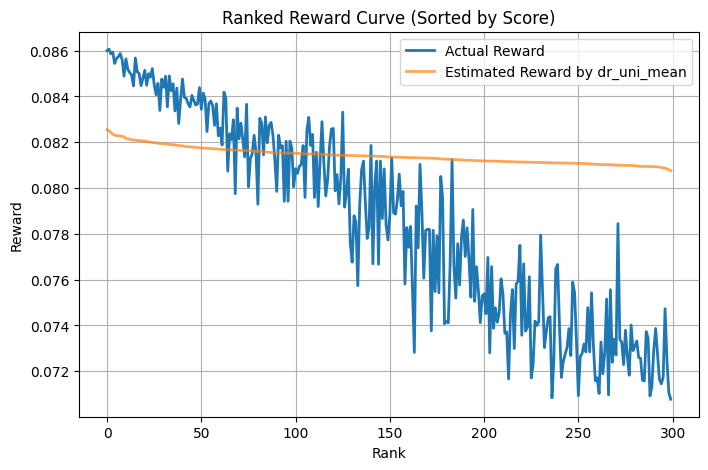

Plotting calibration for: dr_uni_ci_low


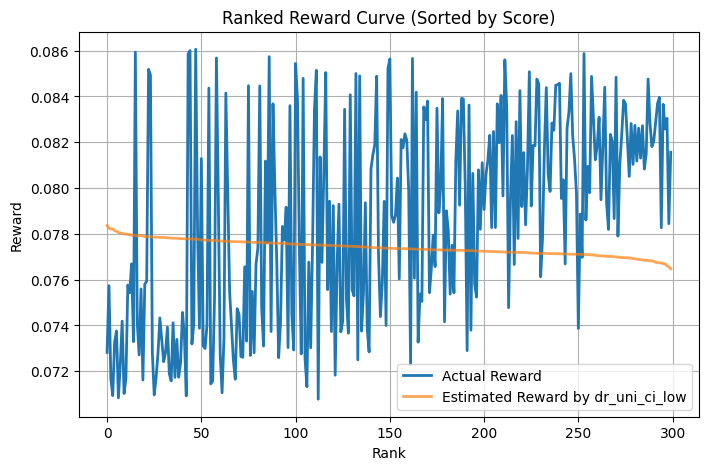

Plotting calibration for: ipw_boot_mean


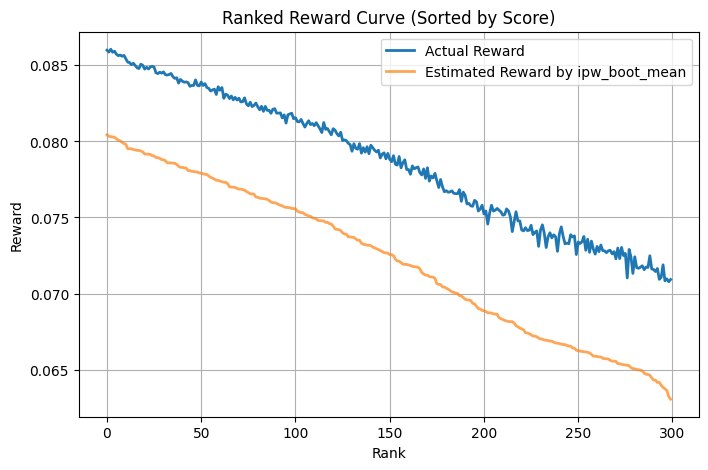

Plotting calibration for: ipw_boot_ci_low


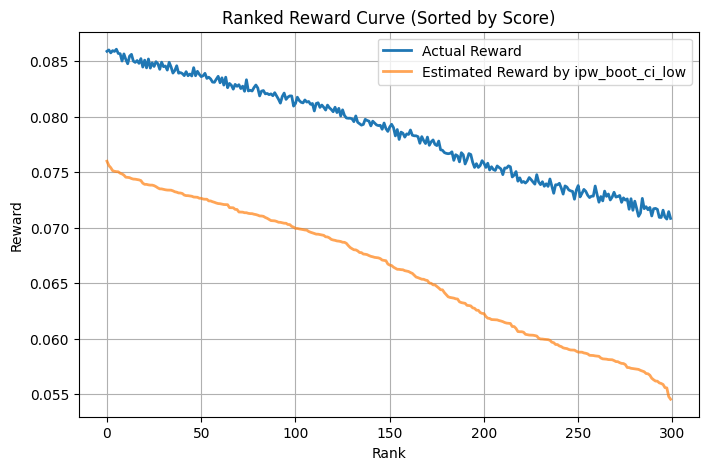

Plotting calibration for: ipw_uni_mean


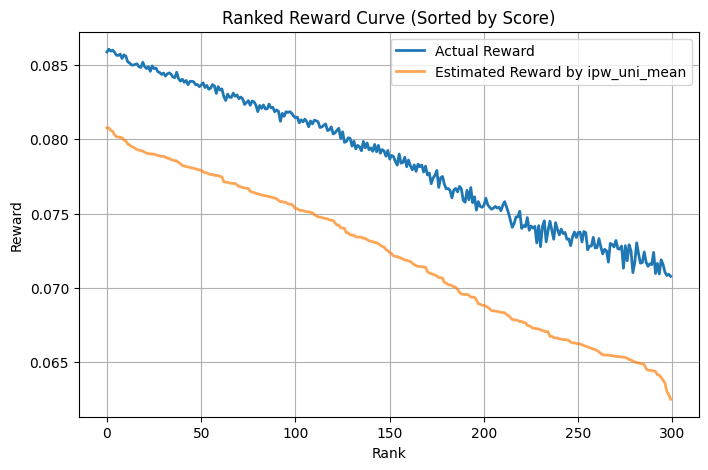

Plotting calibration for: ipw_uni_ci_low


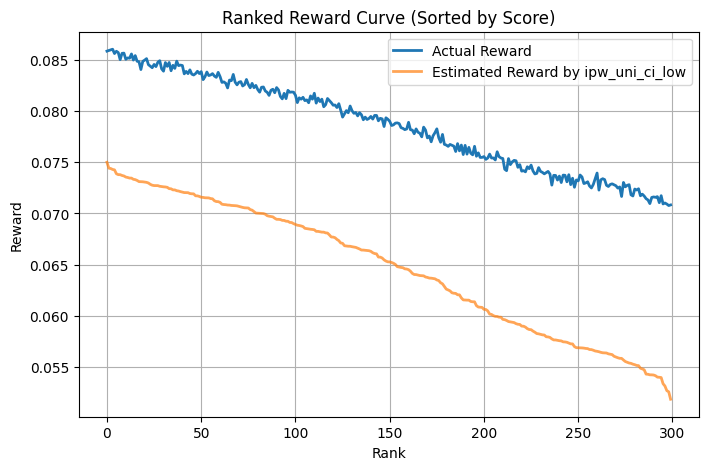

,Spearman-Rank,Kendall-Tau
dr_naive_mean,0.98346515,0.90903010
dr_naive_ci_low,-0.55748397,-0.43201784
dr_boot_mean,0.95251858,0.81319955
dr_boot_ci_low,-0.37008678,-0.26301003
dr_uni_mean,0.94654474,0.79906355
dr_uni_ci_low,-0.52719119,-0.37248606
ipw_boot_mean,0.99751686,0.96111483
ipw_boot_ci_low,0.99717908,0.95620959
ipw_uni_mean,0.99683952,0.95616499
ipw_uni_ci_low,0.99644796,0.95045708


In [15]:
plot_calibration_and_rank_table(
    df,
    cols=cols,
    reward_col="user_attrs_actual_reward"
)

In [11]:
num_runs = 1
batch_size = 200
num_neighbors = 6
n_trials_for_optuna = 155
# num_rounds_list = [500, 1000, 2000, 10000, 20000]
# num_rounds_list = [500, 1000, 2000]
num_rounds_list = [15000]


# Manually define your best parameters
best_params_to_use = {
    "lr": 0.096,  # Learning rate
    "num_epochs": 5,  # Number of training epochs
    "batch_size": 64,  # Batch size for training
    "num_neighbors": 8,  # Number of neighbors for neighborhood model
    "lr_decay": 0.85  # Learning rate decay factor
}


### 1

$$emb = 0.7 * gt + 0.3 * noise$$
$$lr = 0.005$$
$$n_{epochs} = 1$$
$$BatchSize=50$$

In [12]:
print("Value of num_rounds_list:", num_rounds_list)

# Run the optimization
df4, study_df = regression_trainer_trial(num_runs, num_neighbors, num_rounds_list, train_dataset, batch_size, val_size=10000, n_trials=n_trials_for_optuna, prev_best_params=best_params_to_use)

# # Print best hyperparameters for each training size
# print("\n=== BEST HYPERPARAMETERS BY TRAINING SIZE ===")
# for train_size, params in best_hyperparams_by_size.items():
#     print(f"\nTraining Size: {train_size}")
#     # print(f"Best Reward: {params['reward']:.6f}")
#     print("Parameters:")
#     for param_name, value in params['params'].items():
#         print(f"  {param_name}: {value}")
# print("===========================\n")

# Show the performance metrics
df4[['policy_rewards', 'ipw', 'reg_dm', 'conv_dm', 'conv_dr', 'conv_sndr', 'action_diff_to_real', 'action_delta', 'context_diff_to_real', 'context_delta']]

Value of num_rounds_list: [15000]
Simulation time for 10000 samples: 0.018888473510742188 seconds
[Regression] Baseline regression model fit time: 0.09s
Num samples is 10000
{'gini': np.float64(0.4785128361157565), 'ess': np.float64(3766.1384543609033), 'max_wi': np.float64(34.15678561969343), 'min_wi': np.float64(0.00913120999047888)}
Eval time: 0.47662353515625 seconds


[I 2025-12-24 20:31:11,092] A new study created in memory with name: no-name-5d07a2d1-77ee-4d44-abe3-0c5c0f8c3f3b


Evaluation total results time: 0.93 seconds

=== [Regression] Training size 15000, run 0 ===
Simulation time for 25000 samples: 0.04574441909790039 seconds


  0%|          | 0/155 [00:00<?, ?it/s]


[Regression] Optuna Trial 0
actual reward: [0.08334302]


Best trial: 0. Best value: 0.0906728:   1%|          | 1/155 [00:05<14:33,  5.67s/it]

[I 2025-12-24 20:31:16,764] Trial 0 finished with value: 0.0906727703465713 and parameters: {'lr': 0.096, 'num_epochs': 5, 'batch_size': 64, 'lr_decay': 0.85}. Best is trial 0 with value: 0.0906727703465713.

[Regression] Optuna Trial 1
actual reward: [0.09118059]


Best trial: 0. Best value: 0.0906728:   1%|▏         | 2/155 [00:12<15:55,  6.25s/it]

[I 2025-12-24 20:31:23,414] Trial 1 finished with value: 0.08896432170934261 and parameters: {'lr': 0.006955571410181052, 'num_epochs': 9, 'batch_size': 64, 'lr_decay': 0.9728187688037189}. Best is trial 0 with value: 0.0906727703465713.

[Regression] Optuna Trial 2
actual reward: [0.08932512]


Best trial: 0. Best value: 0.0906728:   2%|▏         | 3/155 [00:19<16:53,  6.67s/it]

[I 2025-12-24 20:31:30,585] Trial 2 finished with value: 0.08855910514427424 and parameters: {'lr': 0.0016950076578003412, 'num_epochs': 10, 'batch_size': 64, 'lr_decay': 0.881508831738226}. Best is trial 0 with value: 0.0906727703465713.

[Regression] Optuna Trial 3
actual reward: [0.08642543]


Best trial: 0. Best value: 0.0906728:   3%|▎         | 4/155 [00:21<12:03,  4.79s/it]

[I 2025-12-24 20:31:32,496] Trial 3 finished with value: 0.08169944631806896 and parameters: {'lr': 0.001301486996798868, 'num_epochs': 5, 'batch_size': 512, 'lr_decay': 0.9573804903657039}. Best is trial 0 with value: 0.0906727703465713.

[Regression] Optuna Trial 4
actual reward: [0.08804615]


Best trial: 0. Best value: 0.0906728:   3%|▎         | 5/155 [00:23<09:55,  3.97s/it]

[I 2025-12-24 20:31:35,016] Trial 4 finished with value: 0.08800897976517662 and parameters: {'lr': 0.014869190911611336, 'num_epochs': 7, 'batch_size': 256, 'lr_decay': 0.8746230953944503}. Best is trial 0 with value: 0.0906727703465713.

[Regression] Optuna Trial 5
actual reward: [0.08615435]


Best trial: 0. Best value: 0.0906728:   4%|▍         | 6/155 [00:25<07:53,  3.18s/it]

[I 2025-12-24 20:31:36,644] Trial 5 finished with value: 0.07863106298868586 and parameters: {'lr': 0.0004137815878883676, 'num_epochs': 2, 'batch_size': 256, 'lr_decay': 0.9815560722730744}. Best is trial 0 with value: 0.0906727703465713.

[Regression] Optuna Trial 6
actual reward: [0.08643417]


Best trial: 0. Best value: 0.0906728:   5%|▍         | 7/155 [00:30<09:35,  3.89s/it]

[I 2025-12-24 20:31:42,005] Trial 6 finished with value: 0.08438057703728023 and parameters: {'lr': 0.0005632939204496728, 'num_epochs': 8, 'batch_size': 64, 'lr_decay': 0.8089967956208597}. Best is trial 0 with value: 0.0906727703465713.

[Regression] Optuna Trial 7
actual reward: [0.08614851]


Best trial: 0. Best value: 0.0906728:   5%|▌         | 8/155 [00:33<08:12,  3.35s/it]

[I 2025-12-24 20:31:44,201] Trial 7 finished with value: 0.07852377014333223 and parameters: {'lr': 0.00014891188677631636, 'num_epochs': 8, 'batch_size': 512, 'lr_decay': 0.9624821462145356}. Best is trial 0 with value: 0.0906727703465713.

[Regression] Optuna Trial 8
actual reward: [0.0861149]


Best trial: 0. Best value: 0.0906728:   6%|▌         | 9/155 [00:34<06:41,  2.75s/it]

[I 2025-12-24 20:31:45,625] Trial 8 finished with value: 0.07835234261342884 and parameters: {'lr': 0.00021047992335686668, 'num_epochs': 1, 'batch_size': 512, 'lr_decay': 0.943966054927717}. Best is trial 0 with value: 0.0906727703465713.

[Regression] Optuna Trial 9
actual reward: [0.08650267]


Best trial: 0. Best value: 0.0906728:   6%|▋         | 10/155 [00:36<06:04,  2.51s/it]

[I 2025-12-24 20:31:47,612] Trial 9 finished with value: 0.08711433312203665 and parameters: {'lr': 0.002524860558881514, 'num_epochs': 2, 'batch_size': 128, 'lr_decay': 0.9352147972212416}. Best is trial 0 with value: 0.0906727703465713.

[Regression] Optuna Trial 10
actual reward: [0.08139377]


Best trial: 0. Best value: 0.0906728:   7%|▋         | 11/155 [00:39<06:11,  2.58s/it]

[I 2025-12-24 20:31:50,345] Trial 10 finished with value: 0.08981515735447891 and parameters: {'lr': 0.09275020280943244, 'num_epochs': 5, 'batch_size': 128, 'lr_decay': 0.8292414438095734}. Best is trial 0 with value: 0.0906727703465713.

[Regression] Optuna Trial 11
actual reward: [0.08336489]


Best trial: 0. Best value: 0.0906728:   8%|▊         | 12/155 [00:41<06:06,  2.56s/it]

[I 2025-12-24 20:31:52,859] Trial 11 finished with value: 0.08908550392614231 and parameters: {'lr': 0.08581120266361512, 'num_epochs': 5, 'batch_size': 128, 'lr_decay': 0.8270666775996536}. Best is trial 0 with value: 0.0906727703465713.

[Regression] Optuna Trial 12
actual reward: [0.0849064]


Best trial: 0. Best value: 0.0906728:   8%|▊         | 13/155 [00:44<05:51,  2.48s/it]

[I 2025-12-24 20:31:55,139] Trial 12 finished with value: 0.09008574339449296 and parameters: {'lr': 0.09895660130934696, 'num_epochs': 4, 'batch_size': 128, 'lr_decay': 0.8456253081745747}. Best is trial 0 with value: 0.0906727703465713.

[Regression] Optuna Trial 13
actual reward: [0.08913305]


Best trial: 0. Best value: 0.0906728:   9%|▉         | 14/155 [00:46<05:29,  2.34s/it]

[I 2025-12-24 20:31:57,162] Trial 13 finished with value: 0.0870681272071011 and parameters: {'lr': 0.02616249932963997, 'num_epochs': 3, 'batch_size': 128, 'lr_decay': 0.8454270630800189}. Best is trial 0 with value: 0.0906727703465713.

[Regression] Optuna Trial 14
actual reward: [0.08122765]


Best trial: 0. Best value: 0.0906728:  10%|▉         | 15/155 [00:49<06:19,  2.71s/it]

[I 2025-12-24 20:32:00,743] Trial 14 finished with value: 0.08369607108856368 and parameters: {'lr': 0.03255991846704195, 'num_epochs': 4, 'batch_size': 64, 'lr_decay': 0.9115111877060295}. Best is trial 0 with value: 0.0906727703465713.

[Regression] Optuna Trial 15


Best trial: 0. Best value: 0.0906728:  10%|▉         | 15/155 [00:50<07:49,  3.35s/it]


[W 2025-12-24 20:32:01,344] Trial 15 failed with parameters: {'lr': 0.008547518011818047, 'num_epochs': 6, 'batch_size': 128, 'lr_decay': 0.8594782944092253} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/roee/Documents/code/OPC/.venv/lib/python3.12/site-packages/optuna/study/_optimize.py", line 201, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/home/roee/Documents/code/OPC/trainer_trials_modular.py", line 640, in objective
    trial_reg_model.fit(
  File "/home/roee/Documents/code/OPC/models.py", line 501, in fit
    self.base_model_list[pos_].fit(X, reward[idx])
  File "/home/roee/Documents/code/OPC/.venv/lib/python3.12/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/roee/Documents/code/OPC/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py", line 13

KeyboardInterrupt: 

In [ ]:
study_df.to_csv(f"trial_dfs/study_df_{n_trials_for_optuna}_{12345}.csv")

compute_statistics_and_plots(study_df)

### Policy with delta function

In [ ]:
dataset_params = dict(
                    n_actions= 500,
                    n_users = 500,
                    emb_dim = 16,
                    # sigma = 0.1,
                    eps = 0.6, # this is the epsilon for the noise in the ground truth policy representation
                    ctr = 0.1
                    )

train_dataset = generate_dataset(dataset_params, seed=10000)

In [ ]:
# Run the optimization
df5, study_df5 = regression_trainer_trial(num_runs, num_neighbors, num_rounds_list, train_dataset, batch_size, val_size=10000, n_trials=n_trials_for_optuna, prev_best_params=best_params_to_use)

study_df5.to_csv(f"trial_dfs/study_df_{n_trials_for_optuna}_{10000}.csv")

# Show the performance metrics
df5[['policy_rewards', 'ipw', 'reg_dm', 'conv_dm', 'conv_dr', 'conv_sndr', 'action_diff_to_real', 'action_delta', 'context_diff_to_real', 'context_delta']]

In [ ]:
study_df5

In [ ]:
compute_statistics_and_plots(study_df5)

In [ ]:
dataset_params = dict(
                    n_actions= 500,
                    n_users = 500,
                    emb_dim = 16,
                    # sigma = 0.1,
                    eps = 0.6, # this is the epsilon for the noise in the ground truth policy representation
                    ctr = 0.1
                    )

train_dataset = generate_dataset(dataset_params, seed=20000)

In [ ]:
# Run the optimization
df6, study_df6 = regression_trainer_trial(num_runs, num_neighbors, num_rounds_list, train_dataset, batch_size, val_size=10000, n_trials=n_trials_for_optuna, prev_best_params=best_params_to_use)

study_df6.to_csv(f"trial_dfs/study_df_{n_trials_for_optuna}_{20000}.csv")
# Show the performance metrics
df6[['policy_rewards', 'ipw', 'reg_dm', 'conv_dm', 'conv_dr', 'conv_sndr', 'action_diff_to_real', 'action_delta', 'context_diff_to_real', 'context_delta']]

In [ ]:
compute_statistics_and_plots(study_df6)

In [ ]:
dataset_params = dict(
                    n_actions= 500,
                    n_users = 500,
                    emb_dim = 16,
                    # sigma = 0.1,
                    eps = 0.6, # this is the epsilon for the noise in the ground truth policy representation
                    ctr = 0.1
                    )

train_dataset = generate_dataset(dataset_params, seed=30000)

In [ ]:
# Run the optimization
df7, study_df7 = regression_trainer_trial(num_runs, num_neighbors, num_rounds_list, train_dataset, batch_size, val_size=10000, n_trials=n_trials_for_optuna, prev_best_params=best_params_to_use)

study_df7.to_csv(f"trial_dfs/study_df_{n_trials_for_optuna}_{30000}.csv")
# Show the performance metrics
df7[['policy_rewards', 'ipw', 'reg_dm', 'conv_dm', 'conv_dr', 'conv_sndr', 'action_diff_to_real', 'action_delta', 'context_diff_to_real', 'context_delta']]

In [ ]:
compute_statistics_and_plots(study_df7)

In [ ]:
dataset_params = dict(
                    n_actions= 500,
                    n_users = 500,
                    emb_dim = 16,
                    # sigma = 0.1,
                    eps = 0.6, # this is the epsilon for the noise in the ground truth policy representation
                    ctr = 0.1
                    )

train_dataset = generate_dataset(dataset_params, seed=40000)

In [ ]:
# Run the optimization
df8, study_df8 = regression_trainer_trial(num_runs, num_neighbors, num_rounds_list, train_dataset, batch_size, val_size=10000, n_trials=n_trials_for_optuna, prev_best_params=best_params_to_use)

study_df8.to_csv(f"trial_dfs/study_df_{n_trials_for_optuna}_{40000}.csv")
# Show the performance metrics
df8[['policy_rewards', 'ipw', 'reg_dm', 'conv_dm', 'conv_dr', 'conv_sndr', 'action_diff_to_real', 'action_delta', 'context_diff_to_real', 'context_delta']]

In [ ]:
compute_statistics_and_plots(study_df8)

In [ ]:
dataset_params = dict(
                    n_actions= 500,
                    n_users = 500,
                    emb_dim = 16,
                    # sigma = 0.1,
                    eps = 0.6, # this is the epsilon for the noise in the ground truth policy representation
                    ctr = 0.1
                    )

train_dataset = generate_dataset(dataset_params, seed=50000)

In [ ]:
# Run the optimization
df9, study_df9 = regression_trainer_trial(num_runs, num_neighbors, num_rounds_list, train_dataset, batch_size, val_size=10000, n_trials=n_trials_for_optuna, prev_best_params=best_params_to_use)

study_df9.to_csv(f"trial_dfs/study_df_{n_trials_for_optuna}_{50000}.csv")
# Show the performance metrics
df9[['policy_rewards', 'ipw', 'reg_dm', 'conv_dm', 'conv_dr', 'conv_sndr', 'action_diff_to_real', 'action_delta', 'context_diff_to_real', 'context_delta']]

In [ ]:
compute_statistics_and_plots(study_df9)

In [ ]:
all_dfs = pd.concat([study_df, study_df5, study_df6, study_df7, study_df8, study_df9], ignore_index=True)
all_dfs = all_dfs[all_dfs['value'] > 0]
# all_dfs['user_attrs_actual_reward'] = all_dfs['user_attrs_actual_reward'].apply(lambda x: x[0])

In [ ]:
all_dfs.head(5)

In [ ]:
from plots_and_stats import compute_statistics_and_plots
import pandas as pd

In [ ]:
all_dfs.to_csv(f"trial_dfs/regression_model_opl_study_results_all_seeds_{n_trials_for_optuna}.csv", index=False)

In [ ]:
all_dfs = pd.read_csv(f"regression_model_opl_study_results_all_seeds_{n_trials_for_optuna}.csv")

In [ ]:
compute_statistics_and_plots(all_dfs)